### Main Project Notebook
In this notebook we will use the other .py files in order to train a final model with relatively good accuracy.  
We will go through the following main steps:  
* Overfitting a single batch as good practice in order to make sure we have no bugs or logical errors in our code.  
* Training a first version of our model in which we will rely on a pretrained Resnet18 without modifications to the model weights and use an ImageNet data standardization.  
* Training a second version of our model in which we will modify the Resnet18 model weights and use a custom data standardization.  
* Test our best model with the test set and summarize our results through a confusion matrix.

In [3]:
#Lets set up ouer basic imports as well as variables to use later
import pandas as pd
import numpy as np
import librosa
import librosa.display
import torch
import random
from torch import nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from math import floor
from IPython.display import Audio
from IPython.core.display import display
from torch.utils.tensorboard import SummaryWriter
from data_model_classes import MusicGenres, GenreClassifier
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

device = 'cuda' if torch.cuda.is_available() else 'cpu' #checking for gpu availability

reverse_genredict = {0:"blues", 1:"classical", 2:"country", 3:"disco", 4:"hiphop", 5:"jazz", 6:"metal", 7:"pop", 8:"reggae",9:"rock"}
genre_array = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

path_tensors = r"C:\Users\matan\Desktop\MLDL_Projects\Audio_Classification\Data\spectrogram_tensors\\"
csv_file = r"C:\Users\matan\Desktop\MLDL_Projects\Audio_Classification\Data\features_3_sec.csv"
genres_path = r"C:\Users\matan\Desktop\MLDL_Projects\Audio_Classification\Data\genres_original\\"

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),                          # Resizing for pretrained model
    transforms.Normalize((0.485, 0.456, 0.406),             # normalize for pretrained model
                         (0.229, 0.224, 0.225))
])

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),                          # Resizing for pretrained model
    transforms.Normalize((-39.0525, -39.0525, -39.0525),    # normalize images for training data
                         (14.9446, 14.9446, 14.9446))
])

#### Overfitting a single batch, pretrained Resnet18, ImageNet data standardization

In [4]:
# Preparing our Data for single batch sanity check
base_ds_RT = MusicGenres(csv_file = csv_file, root_dir = path_tensors, transform= resnet_transform)
train_ds_RT, test_ds_RT = torch.utils.data.random_split(base_ds_RT , [0.85, 0.15], generator=torch.Generator().manual_seed(42))
train_loader_RT = DataLoader(train_ds_RT, batch_size= 64, shuffle= True)
test_loader_RT = DataLoader(test_ds_RT, batch_size= 64, shuffle= True)

# Single batch for training
overfit_x , overfit_y = next(iter(train_loader_RT))

# Training loop for single batch overfitting tryout
def overfit_training_loop(model, optimizer, x, y, epochs):
    for e in range(epochs):
        model.train()
        x = x.to(device)
        y = y.to(device)

        scores = model(x)
        loss = F.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e%50 == 0:
            print(f"Trainig loss for iteration {e} is : {loss.item():.4f}")

c:\Users\matan\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
# Training our overfitted model
model_to_overfit = GenreClassifier().to(device)
optimizer= optim.Adam(model_to_overfit.parameters(), lr=1e-3 , weight_decay=1e-4)

overfit_training_loop(model_to_overfit, optimizer, overfit_x, overfit_y, epochs=250)

Trainig loss for iteration 0 is : 2.3187
Trainig loss for iteration 50 is : 0.2777
Trainig loss for iteration 100 is : 0.0923
Trainig loss for iteration 150 is : 0.0501
Trainig loss for iteration 200 is : 0.0326


#### Training first version of our model, fine-tuning Resnet18, ImageNet data standardization

In [6]:
# Creating usefull functions for training
# Check accuracy function for validation during and after training
def check_acc(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc
    
# Training loop function for a full model
def training_loop(model, train_loader, test_loader, optimizer, epochs):
    step_loss = 0     # steps will be used for TB writer
    step_acc = 0
    for e in range(epochs):
        print()
        print(f"Starting epoch {e + 1}")
        print()

        for idx, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            writer.add_scalar('Training loss', loss, global_step= step_loss)
            step_loss += 1

            if idx%25 == 0:
                test_acc = check_acc(model= model, loader= test_loader)
                writer.add_scalar('Test accuracy', test_acc, global_step= step_acc)
                step_acc += 1
                print(f"Trainig loss for epoch {e+1} Batch {idx} is : {loss.item():.4f}")
                print(f"Test accuracy for epoch {e+1} Batch {idx} is : {100*test_acc:.2f}%")
                print()

In [8]:
# Training our first model
# Hyperparams
lr = 1e-3
weight_decay = 1e-4
num_epochs = 10

model_1 = GenreClassifier(train_CNN=False).to(device) #By setting train_CNN=False we only allow the last softmax classification layer weights to be trained
dummy_input = torch.rand(1, 3, 224, 224).to(device)
writer = SummaryWriter(f'TB/model_ver1')
writer.add_graph(model_1, dummy_input)

optimizer= optim.Adam(model_1.parameters(), lr=lr, weight_decay=weight_decay)
training_loop(model_1, train_loader_RT, test_loader_RT, optimizer, epochs= num_epochs)
writer.close()


Starting epoch 1

Trainig loss for epoch 1 Batch 0 is : 2.5658
Test accuracy for epoch 1 Batch 0 is : 9.08%

Trainig loss for epoch 1 Batch 25 is : 1.9622
Test accuracy for epoch 1 Batch 25 is : 36.47%

Trainig loss for epoch 1 Batch 50 is : 1.5853
Test accuracy for epoch 1 Batch 50 is : 47.16%

Trainig loss for epoch 1 Batch 75 is : 1.3911
Test accuracy for epoch 1 Batch 75 is : 51.84%

Trainig loss for epoch 1 Batch 100 is : 1.4730
Test accuracy for epoch 1 Batch 100 is : 53.11%

Trainig loss for epoch 1 Batch 125 is : 1.6414
Test accuracy for epoch 1 Batch 125 is : 55.64%


Starting epoch 2

Trainig loss for epoch 2 Batch 0 is : 1.3384
Test accuracy for epoch 2 Batch 0 is : 55.85%

Trainig loss for epoch 2 Batch 25 is : 1.3189
Test accuracy for epoch 2 Batch 25 is : 58.85%

Trainig loss for epoch 2 Batch 50 is : 1.3148
Test accuracy for epoch 2 Batch 50 is : 58.92%

Trainig loss for epoch 2 Batch 75 is : 1.1878
Test accuracy for epoch 2 Batch 75 is : 59.72%

Trainig loss for epoch 

As we can see, the model is performing quite poorly on the test set and through the last 5 epochs it basically overfits to the training set without improving the accuracy on the test set which reached a max of 70.21%.  
Thus we will try to fine-tune the Resnet18 model weights and use a custom data standardization.

#### Training second version of our model, Full-trained Resnet18, Custom data standardization

In [9]:
# Creating new datasets and loaders with custom data standardization
base_ds_CT = MusicGenres(csv_file = csv_file, root_dir = path_tensors, transform= custom_transform)
train_ds_CT, test_ds_CT = torch.utils.data.random_split(base_ds_CT , [0.85, 0.15], generator=torch.Generator().manual_seed(42))
train_loader_CT = DataLoader(train_ds_CT, batch_size= 64, shuffle= True)
test_loader_CT = DataLoader(test_ds_CT, batch_size= 64, shuffle= True)

In [10]:
# Hyperparams
lr = 1e-4
weight_decay = 1e-4
num_epochs = 10

model_2 = GenreClassifier(train_CNN=True).to(device)
dummy_input = torch.rand(1, 3, 224, 224).to(device)
writer = SummaryWriter(f'TB/model_ver2')
writer.add_graph(model_2, dummy_input)

optimizer= optim.Adam(model_2.parameters(), lr=lr, weight_decay=weight_decay)
training_loop(model_2, train_loader_CT, test_loader_CT, optimizer, epochs= num_epochs)
writer.close()


Starting epoch 1



c:\Users\matan\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Trainig loss for epoch 1 Batch 0 is : 2.4957
Test accuracy for epoch 1 Batch 0 is : 13.89%

Trainig loss for epoch 1 Batch 25 is : 1.0947
Test accuracy for epoch 1 Batch 25 is : 62.46%

Trainig loss for epoch 1 Batch 50 is : 0.9683
Test accuracy for epoch 1 Batch 50 is : 77.49%

Trainig loss for epoch 1 Batch 75 is : 0.5380
Test accuracy for epoch 1 Batch 75 is : 81.56%

Trainig loss for epoch 1 Batch 100 is : 0.4555
Test accuracy for epoch 1 Batch 100 is : 81.23%

Trainig loss for epoch 1 Batch 125 is : 0.3784
Test accuracy for epoch 1 Batch 125 is : 88.31%


Starting epoch 2

Trainig loss for epoch 2 Batch 0 is : 0.3118
Test accuracy for epoch 2 Batch 0 is : 86.04%

Trainig loss for epoch 2 Batch 25 is : 0.2157
Test accuracy for epoch 2 Batch 25 is : 87.84%

Trainig loss for epoch 2 Batch 50 is : 0.1309
Test accuracy for epoch 2 Batch 50 is : 89.18%

Trainig loss for epoch 2 Batch 75 is : 0.2976
Test accuracy for epoch 2 Batch 75 is : 89.65%

Trainig loss for epoch 2 Batch 100 is : 0

#### Testing our best model, Sampling from test set, Summarizing results with confusion matrix  
In this section we will first preform an inference on random samples from the test set, the Sample_Audio function will allow us to try and understand the model's predictions.  
Be aware that although the function displays a colorfull spectrogram, the model receives a grayscale spectrogram as input and the colormap is only for human visualization purposes.  
Finally, we will summarize our results with a confusion matrix.

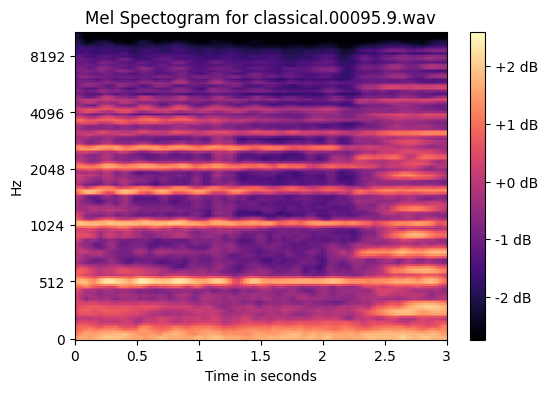

Model prediction is: classical
True genre is: classical


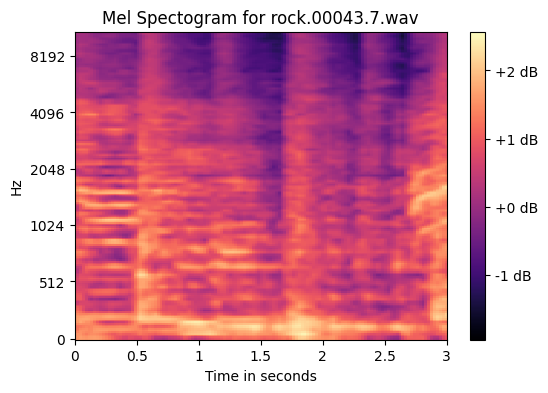

Model prediction is: rock
True genre is: rock


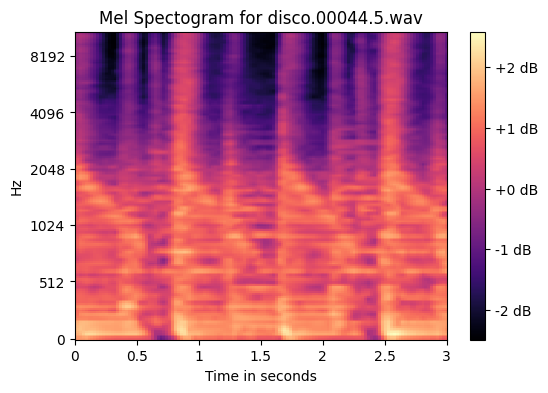

Model prediction is: disco
True genre is: disco


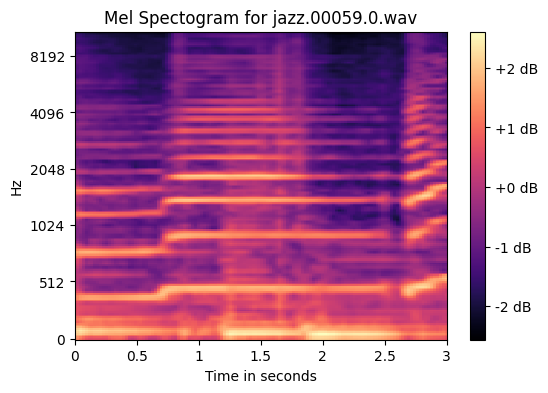

Model prediction is: jazz
True genre is: jazz


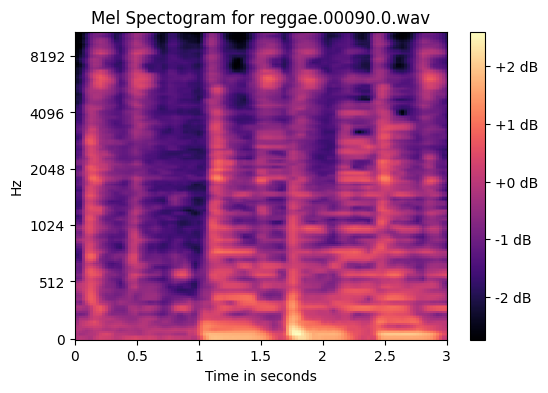

Model prediction is: reggae
True genre is: reggae


In [11]:
def Sample_Audio(model, genres_path, dataset= test_ds_CT, num_samples=5):
    model.eval()

    with torch.no_grad():
        for i in range(num_samples):
            rnd_id = floor(random.random()*len(dataset))
            og_id = dataset.indices[rnd_id]
            snip_name = base_ds_CT.annotations.iloc[og_id, 0]
            blocks = snip_name.split('.')
            file_name = blocks[0] + '.' + blocks[1] + '.' + blocks[3]

            x , y = dataset[rnd_id]
            x = x.to(device)
            x = x.unsqueeze(0)
            scores = model(x)
            _ , prediction = scores.max(1)

            pred_label , true_label = reverse_genredict[prediction.item()] , reverse_genredict[y]  

            full_path = genres_path + true_label + '\\' + file_name

            #Plotting melspectogram with colors, important to understand that the models input is greyscale without colors!
            mel_spec = x.squeeze()[0].cpu().numpy()    # squeeze for removing batch dim, slice to get only one channel    
            plt.figure(figsize=(6,4))
            librosa.display.specshow(mel_spec, cmap='magma', y_axis='mel', x_axis='time')
            plt.xlim(0, 3.0)
            plt.xlabel('Time in seconds')
            plt.colorbar(format= '%+2.0f dB')
            plt.title(f'Mel Spectogram for {snip_name}')
            plt.show()

            #Displaying a mediaplayer for the audiofile
            display(Audio(fr'{full_path}'))

            print(f"Model prediction is: {pred_label}")
            print(f"True genre is: {true_label}")

Sample_Audio(model_2, genres_path, dataset= test_ds_CT)

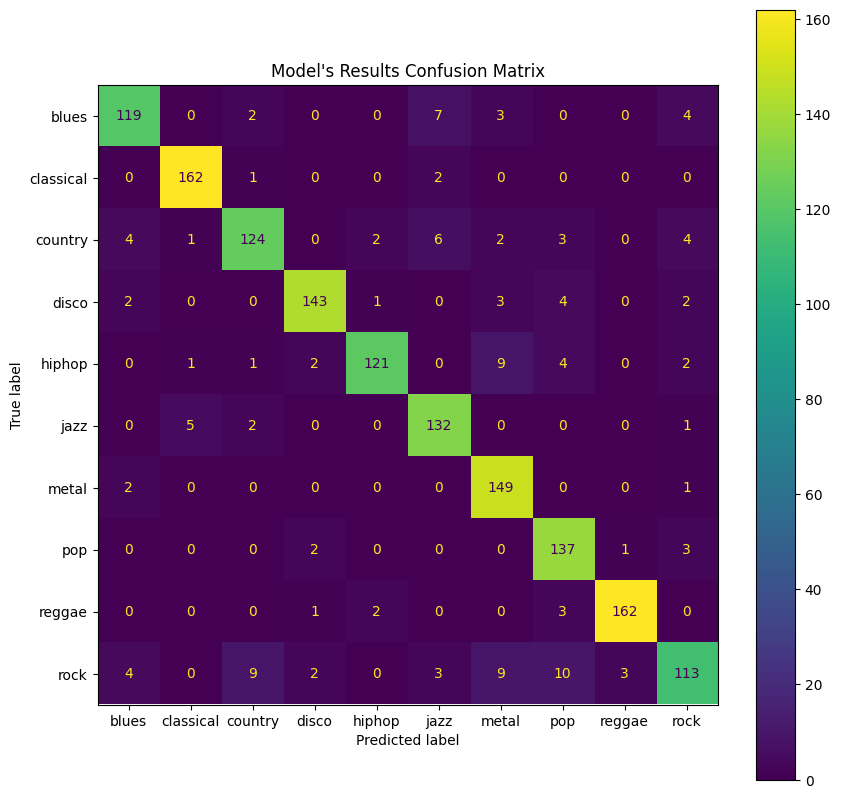

In [12]:
def Confusion_Matrix(model, dataloader= test_loader_CT, label_dict= reverse_genredict, labels_lis=genre_array):
    predicted_labels = []
    true_labels = []

    model.eval()
    with torch.no_grad():
        for x,y in dataloader:
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            scores = model(x)
            _, preds = scores.max(1)

            tmp_pred_lbls = [label_dict[i] for i in preds.cpu().numpy()]
            tmp_true_lbls = [label_dict[i] for i in y.cpu().numpy()]

            predicted_labels += tmp_pred_lbls
            true_labels += tmp_true_lbls

        matrix = confusion_matrix(true_labels, predicted_labels, labels=labels_lis)
        display = ConfusionMatrixDisplay(matrix, display_labels=labels_lis)
        _ , ax = plt.subplots(figsize=(10,10))
        display.plot(ax=ax)
        plt.title("Model's Results Confusion Matrix")
        plt.show()

Confusion_Matrix(model_2)

#### Summary and forward suggestions
As we can see, our model_2 is performing quite well on the test set with an accuracy of ~93% and the decision to train all the model's weights and to perform a custom data standardization was a good one.   
By analyzing the confusion matrix we can see that the model is having a hard time classifying especially the "rock" class, which is understandable since it is a very broad genre.  
Nevertheless, as a future suggestion it is possible to perform another training session with emphasis on the "rock" class and other mistaken classes in order to improve the model's accuracy. 